In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from scipy import ndimage
from skimage.feature import peak_local_max
from sklearn.cluster import DBSCAN, AffinityPropagation, MeanShift
from matplotlib import cm
from skimage.segmentation import chan_vese
from scipy import ndimage
from skimage.morphology import watershed

In [2]:
MIN = 0
MAX = 2 ** 16 - 1

In [3]:
# import all images per sequence, return images
def import_sequences():
    PATH = '../sequences/0'
    imgs = []
    for i in range(1, 5):
        imgs_path = []
        for image in glob(f'{PATH}{i}/*.tif'):
            img = cv2.imread(image, -1)
            imgs_path.append(cv2.normalize(img, dst=None, alpha=MIN, beta=MAX, norm_type=cv2.NORM_MINMAX))
        imgs.append(imgs_path)
    return imgs

In [4]:
imgs = import_sequences()

In [5]:
NROWS = imgs[0][0].shape[0]
NCOLS = imgs[0][0].shape[1]
NUM_IMAGES = len(imgs[0])

In [6]:
# show an image inline
def show(img, s=True):
    plt.figure(figsize=(15,15))
    plt.imshow(img, cmap='gray')
    if s:
        plt.show()

In [7]:
# segment original image using thresholding
def segment(original):
    img = np.zeros_like(original)
    cv2.threshold(original, dst=img, thresh=np.median(original)*1.2, maxval=MAX, type=cv2.THRESH_BINARY)
    struct_element = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(5,5))
    img1 = np.zeros_like(original)
    cv2.morphologyEx(img, dst=img1, op=cv2.MORPH_OPEN, kernel=struct_element, borderValue=cv2.BORDER_REFLECT)
    img2 = np.zeros_like(original)
    cv2.threshold(img1, dst=img2, thresh=MAX-1, maxval=MAX, type=cv2.THRESH_BINARY)
    return img2

In [8]:
# segment the image using Chan-Vese Level Set Method, then processing steps
def segment_CV(img):
    img_cv = chan_vese(img, mu=5, lambda1=1, lambda2=1, tol=1e-3,
                dt=3, init_level_set="checkerboard",
                extended_output=True)[0]
    vals = np.unique(img_cv, return_counts=True)[1]
    if vals[0] < vals[1]:
        img = np.logical_not(img_cv).astype('uint16') * MAX
    else:
        img = img_cv.astype('uint16') * MAX
    pts = points(img)
    mask = np.zeros((6,6))
    mask[1:-1,1:-1] = np.ones((4,4)) * MAX
    delete = {}
    for (i,j) in pts:
        if (i,j) in delete:
            continue
        if i-1 < 0 or i+5 > NROWS-1 or j-1 < 0 or j+5 > NCOLS-1:
            continue
        if np.array_equal(mask, img[i-1:i+5,j-1:j+5]):
            for m in range(4):
                for n in range(4):
                    delete[(i+m,j+n)] = None
    for pt in delete:
        del pts[pt]
    pts, _ = flush_border_cells(pts, create_img(pts))
    for i in range(2):
        pts = dilate(pts)
    for i in range(2):
        pts = erode(pts)
    img = create_img(pts).astype('uint16')
    imgb = np.zeros_like(img)
    imgb = cv2.GaussianBlur(img, dst=imgb, ksize=(0,0), sigmaX=4)
    imgb = cv2.threshold(imgb, dst=imgb, thresh=40000, maxval=MAX, type=cv2.THRESH_BINARY)[1]
    return imgb

In [9]:
# get white points of an image, return dict of coord tuples
def points(img):
    pts = {}
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] == MAX:
                pts[(i,j)] = None
    return pts

In [10]:
# flush all cells that touch the border of the image
def flush_border_cells(pts, img):
    to_check = []
    border_pts = {}
    border_img = np.zeros((NROWS, NCOLS))
    for pt in pts:
        if pt[0] == 0 or pt[1] == 0 or pt[0] == NROWS-1 or pt[1] == NCOLS-1:
            to_check.append(pt)
            border_pts[pt] = None
            border_img[pt[0], pt[1]] = MAX
    while len(to_check) > 0:
        b_pt = to_check.pop(0)
        for i in range(-1, 2):
            for j in range(-1, 2):
                if (b_pt[0]+i, b_pt[1]+j) in pts and (b_pt[0]+i, b_pt[1]+j) not in border_pts:
                    to_check.append((b_pt[0]+i, b_pt[1]+j))
                    border_pts[(b_pt[0]+i, b_pt[1]+j)] = None
                    border_img[b_pt[0]+i, b_pt[1]+j] = MAX
    '''
    cnt = 0
    while cnt < 50000:
        if len(to_check) == 0:
            break
        if cnt == 49999:
            print(len(to_check))
        b_pt = to_check.pop(0)
        for i in range(-1, 2):
            for j in range(-1, 2):
                if (b_pt[0]+i, b_pt[1]+j) in pts and (b_pt[0]+i, b_pt[1]+j) not in border_pts:
                    to_check.append((b_pt[0]+i, b_pt[1]+j))
                    border_pts[(b_pt[0]+i, b_pt[1]+j)] = None
                    border_img[b_pt[0]+i, b_pt[1]+j] = MAX
        cnt += 1
    '''
    new = img - border_img
    return points(new), new.astype('uint16')

In [11]:
# create an image from points
def create_img(pts):
    new = np.zeros((NROWS, NCOLS))
    for (i, j) in pts:
        new[i, j] = MAX
    return new.astype('uint16')

In [12]:
# binary erosion of points with 3x3 filter
def erode(pts):
    eroded1_pts = {}
    for (x,y) in pts:
        if (x,y-1) in pts and (x, y+1) in pts:
            eroded1_pts[(x,y)] = pts[(x,y)]
    eroded2_pts = {}
    for (x,y) in eroded1_pts:
        if (x-1,y) in eroded1_pts and (x+1, y) in eroded1_pts:
            eroded2_pts[(x,y)] = eroded1_pts[(x,y)]
    return eroded2_pts

In [13]:
# binary dialtion of points with 3x3 filter
def dilate(pts):
    dilated1_pts = pts.copy()
    for (x,y) in pts:
        if (x,y-1) not in pts and check_coords((x,y-1)):
            dilated1_pts[(x, y-1)] = pts[(x,y)]
        if (x, y+1) not in pts and check_coords((x,y+1)):
            dilated1_pts[(x, y+1)] = pts[(x,y)]
    dilated2_pts = dilated1_pts.copy()
    for (x,y) in dilated1_pts:
        if (x-1,y) not in dilated1_pts and check_coords((x-1,y)):
            dilated2_pts[(x-1, y)] = dilated1_pts[(x,y)]
        if (x+1, y) not in dilated1_pts and check_coords((x+1,y)):  
            dilated2_pts[(x+1, y)] = dilated1_pts[(x,y)]
    return dilated2_pts

In [14]:
# check coords within image bounds
def check_coords(pt):
    if pt[0] < 0 or pt[0] > NROWS-1 or pt[1] < 0 or pt[1] > NCOLS-1:
        return False
    return True

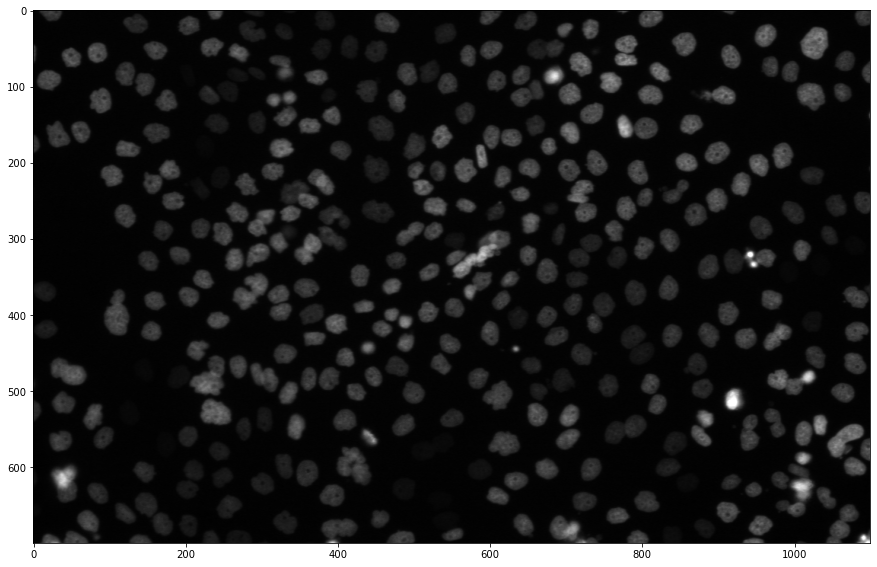

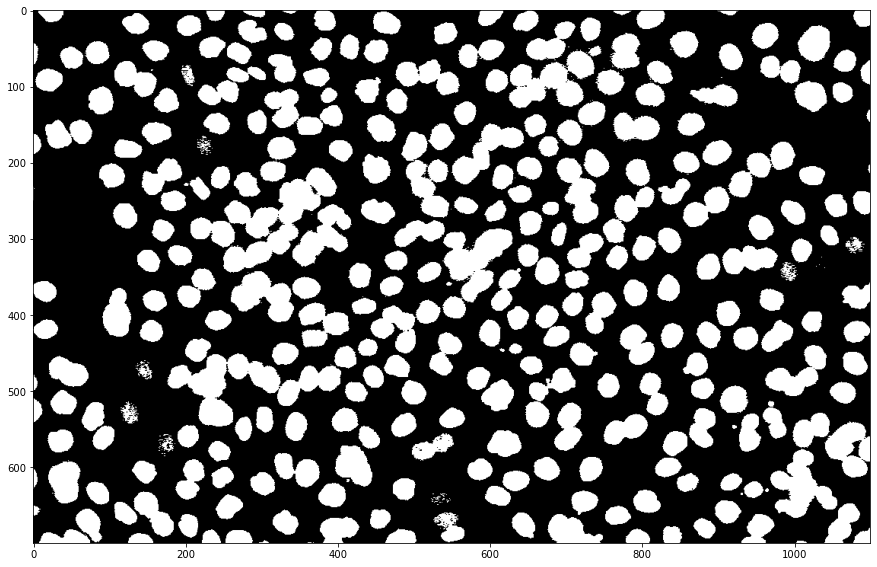

In [15]:
img = imgs[1][-1]
idx = 92

clahe = cv2.createCLAHE(clipLimit=150, tileGridSize=(1,1))
cl = clahe.apply(img)
seg1 = segment(img)
size = len(points(seg1))
hist = cv2.calcHist([cl],[0],None,[MAX+1],[0,MAX+1])
down = np.flip(hist)
count = 0
#factor = idx * (0.3 / 92) + 0.5
for intensity, _ in enumerate(down):
    if count + down[intensity] > size * 0.9:
        break
    count += down[intensity]
seg = np.zeros_like(img)
cv2.threshold(cl, dst=seg, thresh=(MAX - intensity), maxval=MAX, type=cv2.THRESH_BINARY)
show(img)
show(seg)